# Stanford Dogs - A Classfication problem

Classification is a fundamental task in machine learning, and the Stanford Dogs Dataset provides a valuable resource for training and evaluating classification models. The dataset consists of images of various dog breeds, each labeled with the corresponding breed.

By leveraging this dataset, we can develop a classification model that can accurately identify the breed of a given dog image. This can have practical applications in areas such as pet identification, animal welfare, and breed-specific research.

To build a classification model using the Stanford Dogs Dataset, we can employ various machine learning techniques, such as convolutional neural networks (CNNs). CNNs are particularly effective for image classification tasks, as they can automatically learn relevant features from the input images.

By training a CNN on the Stanford Dogs Dataset, we can teach the model to recognize distinctive patterns and characteristics of different dog breeds. Once trained, the model can be used to classify new dog images, providing predictions about the breed with a certain level of confidence.

Evaluation of the classification model can be done using metrics such as accuracy, precision, recall, and F1 score. These metrics help assess the model's performance and determine its effectiveness in correctly classifying dog breeds.

Overall, the Stanford Dogs Dataset offers a valuable opportunity to explore and develop classification models for dog breed identification. By leveraging this dataset and employing appropriate machine learning techniques, we can contribute to the field of computer vision and enhance our understanding of dog breeds.

## 00 - Preprocessing ⚙️

The dataset is split into two parts - Images and Annotations. 

The **Images** are pictures of the 120 different dog breeds present in the dataset. 
The **Annotations** are `.xml`-files, which contains information about where the dog is located in the different pictures and what breed it is.

So first of all we need to load all of these informations into Python, so they can be used to train our model.

Image shape: (64, 64, 3)


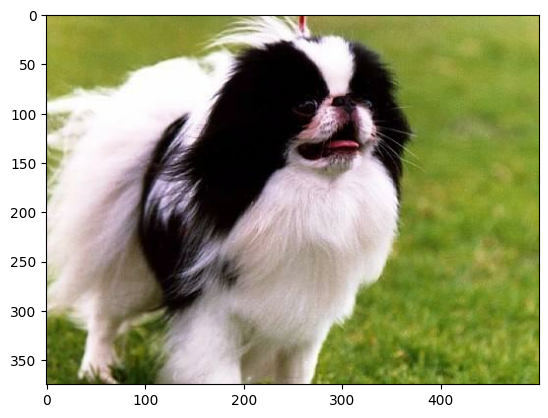

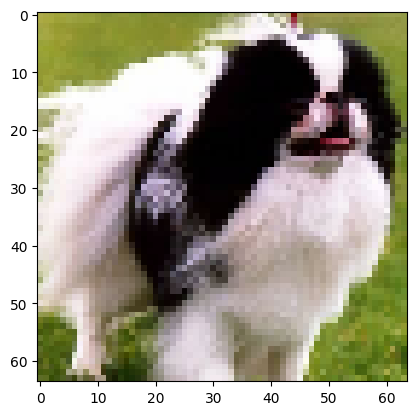

Image shape: (64, 64, 3)


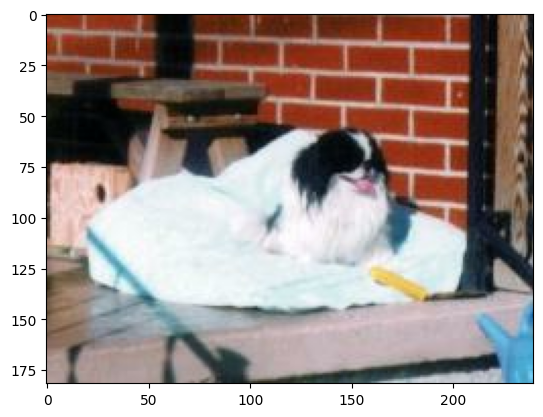

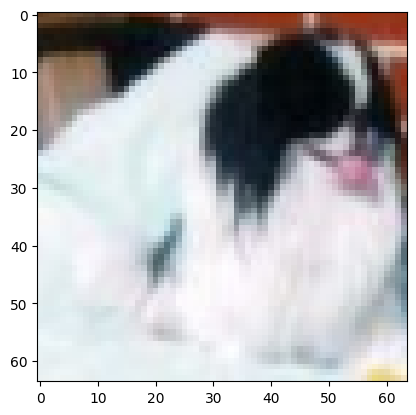

Image shape: (64, 64, 3)


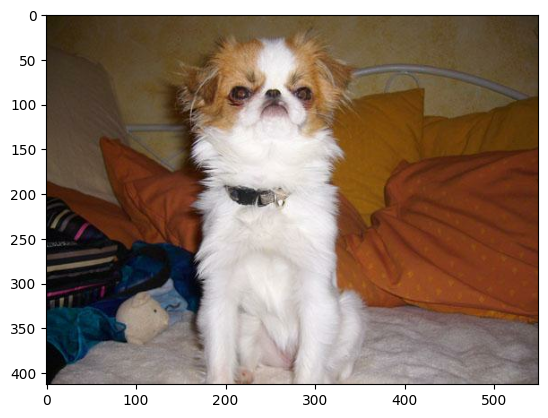

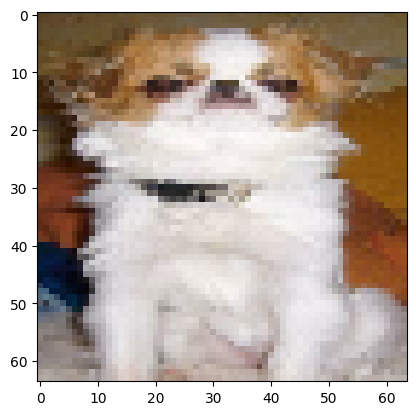

Image shape: (64, 64, 3)


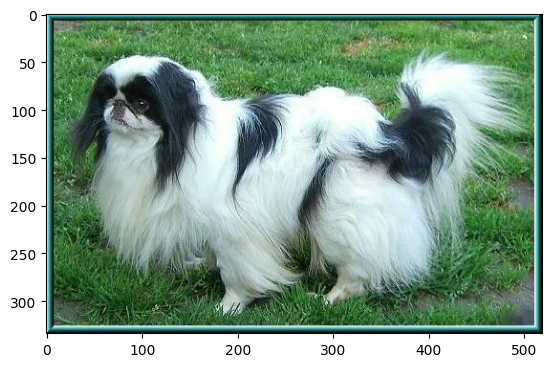

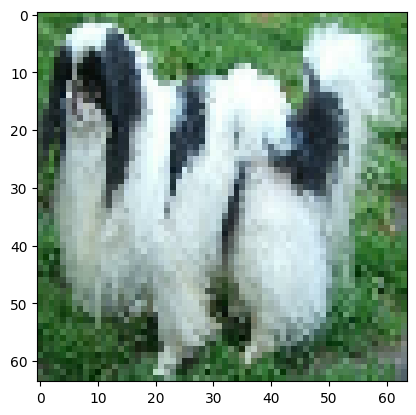

Image shape: (64, 64, 3)


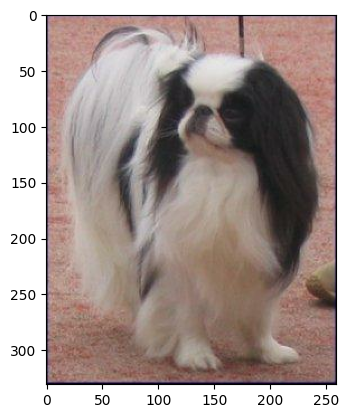

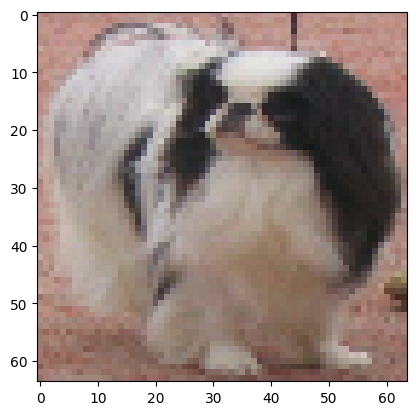


Subset Dataset
Image shape: (64, 64, 3) Label: 0
Image shape: (64, 64, 3) Label: 0
Image shape: (64, 64, 3) Label: 0
Image shape: (64, 64, 3) Label: 0
Image shape: (64, 64, 3) Label: 0


In [11]:
import random
import tensorflow as tf
import xml.etree.ElementTree as ET
import os

# - Parses the annotation XML file to extract the bounding box coordinates
def parse_xml(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # * Extract the bounding box coordinates
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    return xmin, ymin, xmax, ymax

def show_image(image):
    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.axis
    plt.show()

def show_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    show_image(image)

# - Loads the image and crops it based on the bounding box coordinates
def load_image_and_crop(path, annotation_path):
    
    # * Decode the path to a string
    path = path.numpy().decode('utf-8')
    annotation_path = annotation_path.numpy().decode('utf-8')
    
    # * Get the bounding box coordinates
    xmin, ymin, xmax, ymax = parse_xml(annotation_path)
    
    # * Load the image and crop it
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image[ymin:ymax, xmin:xmax]
    return image

# - Preprocesses the image by resizing and normalizing it
def preprocess_image(image):

    # * Resize the image to be 224x224 pixels
    image = tf.image.resize(image, [64, 64])

    # * Normalize the image (Which means converting the pixel values to be between -0.5 and 0.5)
    image = (image / 255.0)
    return image

# - Combines the above functions to load and preprocess the image
def load_and_preprocess_image(path, annotation_path):

    # * Get the cropped image
    image = tf.py_function(func=load_image_and_crop, inp=[path, annotation_path], Tout=tf.uint8)
    # * Set the shape of the image
    image.set_shape([None, None, 3])

    # * Preprocess the image
    image = preprocess_image(image)

    # * Return the image
    return image

# - Creates a map over the breed labels
def make_breed_map(image_dir):
    # * Get the breed labels
    breed_labels = os.listdir(image_dir)

    # * Create a dictionary to map the breed labels to integers
    breed_label_map = {breed: idx for idx, breed in enumerate(breed_labels)}
    return breed_label_map

# - Prepares the dataset by loading and preprocessing the images
def prepare_dataset(image_dir, annotation_dir, breed_label_map):
    
    # * Initialize lists to store the image and annotation paths
    image_paths = []
    labels = []

    # * Loop through the breed directories and extract the image and annotation paths
    for breed_dir in os.listdir(image_dir):
        breed_image_dir = os.path.join(image_dir, breed_dir) # ? Line to get the image directory for the breed.
        breed_annotation_dir = os.path.join(annotation_dir, breed_dir) # ? Line to get the annotation directory for the breed.
        breed_label = breed_label_map[breed_dir] # ? Add this line to get the breed.

        # * Loop through the image files and get the image paths, annotation paths, and labels
        for image_file in os.listdir(breed_image_dir):
            
            # Find the image path
            image_path = os.path.join(breed_image_dir, image_file)
            annotation_path = os.path.join(breed_annotation_dir, image_file.split('.')[0] + '.xml')

            # Append the image path, annotation path, and label to the lists
            image_paths.append(image_path)
            labels.append(breed_label)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x, annotation_path), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# * Define the image and annotation directories for the dataset
image_dir = 'data/images'
annotation_dir = 'data/annotation-xml'

# ? Test the load_and_preprocess_image function for the first 5 images
image_path = 'data/images/n02085782-Japanese_spaniel'
annotation_path = 'data/annotation-xml/n02085782-Japanese_spaniel'

for image_file in os.listdir(image_path)[:5]:

    image = load_and_preprocess_image(os.path.join(image_path, image_file), os.path.join(annotation_path, image_file.split('.')[0] + '.xml'))
    print('Image shape:', image.shape)
    show_image_from_path(os.path.join(image_path, image_file))

    show_image(image)

# * Initialize the dataset
#dataset = prepare_dataset(image_dir, annotation_dir, make_breed_map(image_dir))

# * Print the shape of the first 5 images
#print('Dataset')
#for image, label in dataset.take(5):
#    print('Image shape:', image.shape, 'Label:', label.numpy())

# ? Prepare dataset by loading and preprocessing the images (But with variable procent of the dataset)
def prepare_subset_dataset(image_dir, annotation_dir, label_map, fraction=0.5):
    image_paths = []
    labels = []

    for breed_dir in os.listdir(image_dir):
        breed_image_dir = os.path.join(image_dir, breed_dir)
        breed_annotation_dir = os.path.join(annotation_dir, breed_dir)
        breed_label = label_map[breed_dir]

        # List all images and shuffle
        all_images = os.listdir(breed_image_dir)
        random.shuffle(all_images)  # Shuffle to randomize selection

        # Select a subset of images
        subset_size = int(len(all_images) * fraction)
        selected_images = all_images[:subset_size]

        for image_file in selected_images:
            image_path = os.path.join(breed_image_dir, image_file)
            annotation_path = os.path.join(breed_annotation_dir, image_file.split('.')[0] + '.xml')
            image_paths.append(image_path)
            labels.append(breed_label)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x, annotation_path), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

subset_dataset = prepare_subset_dataset(image_dir, annotation_dir, make_breed_map(image_dir), 0.25)

# ? Print the shape of the first 5 images
print('\nSubset Dataset')
for image, label in subset_dataset.take(5):
    print('Image shape:', image.shape, 'Label:', label.numpy())





Now the Images and Annotations have been loaded into Python. So the next step is to split the dataset into three parts: *Train*, *Test* and *Validation*.

We have chosen to do the typical ``70-20-10`` split

In [12]:
import tensorflow as tf

def split_dataset(to_split, train_ratio=0.7, val_ratio=0.1, shuffle=True, seed=None, buffer_size=10000):
    # ? Shuffle the dataset if shuffle is True
    if shuffle:
        # * Shuffle the dataset to randomize the order
        to_split = to_split.shuffle(buffer_size=buffer_size, seed=seed, reshuffle_each_iteration=False)

    # * Calculate the total number of samples
    total_samples = tf.data.experimental.cardinality(to_split).numpy()

    # - Calculate the number of samples for the training set and validation set
    train_samples = int(total_samples * train_ratio)
    val_samples = int(total_samples * val_ratio)

    # * Split the dataset into training and test sets
    train_dataset = to_split.take(train_samples)
    remaining_dataset = to_split.skip(train_samples)

    # * Split the test set into validation and test sets
    val_dataset = remaining_dataset.take(val_samples)
    test_dataset = remaining_dataset.skip(val_samples)

    # * Return the datasets as train, validation, and test
    return train_dataset, val_dataset, test_dataset

# - Split the dataset into training, validation, and testing datasets
#train_dataset, test_dataset, val_dataset = split_dataset(dataset)

# * Output the dataset sizes and their approximate precentage of the total dataset
#total_samples = tf.data.experimental.cardinality(dataset).numpy()
#train_samples = tf.data.experimental.cardinality(train_dataset).numpy()
#val_samples = tf.data.experimental.cardinality(val_dataset).numpy()
#test_samples = tf.data.experimental.cardinality(test_dataset).numpy()

#print(f'Total samples (Dataset): {total_samples}\n')
#print('Number of samples in the training set:', train_samples, f'({train_samples / total_samples:.2%})')
#print('Number of samples in the validation set:', val_samples, f'({val_samples / total_samples:.2%})')
#print('Number of samples in the test set:', test_samples, f'({test_samples / total_samples:.2%})')


#print('\n')

# - Split the subset dataset into training, validation, and testing datasets
train_subset_dataset, test_subset_dataset, val_subset_dataset = split_dataset(subset_dataset)

# * Output the dataset sizes and their approximate precentage of the total dataset
total_samples_sub = tf.data.experimental.cardinality(subset_dataset).numpy()
train_samples_sub = tf.data.experimental.cardinality(train_subset_dataset).numpy()
val_samples_sub = tf.data.experimental.cardinality(val_subset_dataset).numpy()
test_samples_sub = tf.data.experimental.cardinality(test_subset_dataset).numpy()

print(f'Total samples (Subset): {total_samples_sub}\n')
print('Number of samples in the training set:', train_samples_sub, f'({train_samples_sub / total_samples_sub:.2%})')
print('Number of samples in the validation set:', val_samples_sub, f'({val_samples_sub / total_samples_sub:.2%})')
print('Number of samples in the test set:', test_samples_sub, f'({test_samples_sub / total_samples_sub:.2%})')

Total samples (Subset): 5100

Number of samples in the training set: 3570 (70.00%)
Number of samples in the validation set: 1020 (20.00%)
Number of samples in the test set: 510 (10.00%)


## 01 - Compiling the model 🔧

The next step in the process is to compile the model itself. But before that we have define what **Loss function**, **Optimizer** and **Metrics** we are going to be using on this model.

For the **Loss function** We have a few different options:

(*Name a few different loss functions that would make sense to use for this project.*)

For the **Optizimers** we also have a few different options:
- *Adam*, *SGD*, *RMSProp* etc.

For the **Metrcis** we also have a few different options:
- *Accuarcy*, *PRecision*, *Recall*, *F1 score* etc.


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_sub_model.keras', save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# Model architecture with Batch Normalization
model = Sequential([
    InputLayer(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])

# Compile the model with learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_subset_dataset.batch(32),
    validation_data=val_subset_dataset.batch(32),
    epochs=20,  # Increased epochs
    callbacks=callbacks
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 197ms/step - accuracy: 0.0061 - loss: 28.0905 - val_accuracy: 0.0137 - val_loss: 4.7906 - learning_rate: 0.0100
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.0124 - loss: 4.7860 - val_accuracy: 0.0147 - val_loss: 4.7941 - learning_rate: 0.0100
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.0124 - loss: 4.7837 - val_accuracy: 0.0147 - val_loss: 4.7970 - learning_rate: 0.0100
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.0103 - loss: 4.7830 - val_accuracy: 0.0147 - val_loss: 4.7989 - learning_rate: 0.0100
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.0095 - loss: 4.7805 - val_accuracy: 0.0147 - val_loss: 4.7998 - learning_rate: 0.0050
Epoch 6/20


KeyboardInterrupt: 

## 02 - Train the model 🧠

The next step in the process is to train the now compiled model on our data. Here we also have a little exploratory work in figuring out:
- What *batch size* should we use?
- What *number of epochs* should we use?
- Is the model *overfitting* or *underfitting*?



## Futher plan!

1. **Choose the model architecture suitable for our problem** 🤔
    - Convolutional Neural Network (CNN - Good with Image data)
    - Recurrent Neural Network (RNN - Good with sequence data)
    - Another type??

2. **Compile our model** 🔧
    - What *Loss function* should we use? - Cross-entropy is used for classification?
    - What *Optimizer* should we use? Adam, SGD, RMSProp etc.
    - What *Metrics* should we use? Accuracy, precision, recall, f1 score etc.

3. **Train the model** ⚙️
    - What *batch size* should we use?
    - What *number of epochs* should we use?
    - Is the model *overfitting* or *underfitting*?

4. **Evalute the model** 📊
    - Is the model performing as we would like? Based upon our selected metrics to be unbiased 😉

5. **Tune Hyperparameter (Optional) - To improve performance** 📈
    - Use grid search or another thing similar to find the best hyperparameters
    - Adjust model layers, units, learning rate etc.

6. **Save the Model (Optional) - But would be smart** 🧠
    - This can be done, so we don't have to run all the code later to get the model up and running!

7. **Use the Model!**